<h1>Question 4: SVM</h1>

In [1]:
%run Common.ipynb

%matplotlib inline

def fit_predict_and_plot(clf, train_data, train_labels, test_data, test_labels, class_names):
    clf.fit(train_data, train_labels)

    prob = clf.decision_function(test_data)
    pred = clf.predict(test_data)

    fpr, tpr, _ = roc_curve(test_labels, prob)

    plot_roc(fpr, tpr)
    
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    print_scores(test_labels, pred)
    
    return clf

<h3>Import Lemmatized Datasets</h3>

In [2]:
import pickle

with open('train_lemmatized.pickle', 'rb') as handle:
    train_ds = pickle.load(handle)
    
with open('test_lemmatized.pickle', 'rb') as handle:
    test_ds = pickle.load(handle)

<h2>Map documents to two classes: "Computer Technology" and "Recreational Activity"</h2>

In [3]:
comp_categories = [ 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware','comp.graphics',  'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.sport.baseball','rec.motorcycles',  'rec.sport.hockey']

In [4]:
# map targets to target names
targets = [train_ds.target_names[i] for i in train_ds.target]
targets[0:10]

['rec.sport.baseball',
 'rec.sport.hockey',
 'rec.autos',
 'comp.sys.ibm.pc.hardware',
 'comp.os.ms-windows.misc',
 'comp.sys.mac.hardware',
 'comp.graphics',
 'rec.sport.hockey',
 'rec.motorcycles',
 'comp.sys.mac.hardware']

In [5]:
# assign classes to train documents
for i, target in enumerate(targets):
    if target in comp_categories:
        train_ds.target[i] = 0
    else:
        train_ds.target[i] = 1

In [6]:
np.unique(train_ds.target)

array([0, 1])

In [7]:
train_ds.target_names = ["Computer Technology", "Recreational Activity"]

In [8]:
train_ds.target[0:10]

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0])

In [9]:
targets = [test_ds.target_names[i] for i in test_ds.target]
targets[0:10]

['comp.sys.mac.hardware',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.sys.mac.hardware',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.sys.ibm.pc.hardware',
 'rec.sport.baseball',
 'comp.graphics',
 'comp.os.ms-windows.misc']

In [10]:
# assign classes to test documents
for i, target in enumerate(targets):
    if target in comp_categories:
        test_ds.target[i] = 0
    else:
        test_ds.target[i] = 1

In [11]:
test_ds.target_names = ["Computer Technology", "Recreational Activity"]

In [12]:
test_ds.target[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

<h2>Construct Pipeline</h2>

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

reduction_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=3, stop_words = 'english')),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0))
])

# datasets are already lemmatized, so no lemmatization needed here

%time train_lsi = reduction_pipeline.fit_transform(train_ds.data, train_ds.target)
test_lsi = reduction_pipeline.transform(test_ds.data)

CPU times: user 6.15 s, sys: 331 ms, total: 6.48 s
Wall time: 3.06 s


In [14]:
print("Train TFIDF LSI shape: %s" %str(train_lsi.shape))
print("Test TFIDF LSI shape: %s" %str(test_lsi.shape))

Train TFIDF LSI shape: (4732, 50)
Test TFIDF LSI shape: (3150, 50)


<h3>Serialize objects to be used later</h3>

In [15]:
import pickle

with open('train_lemmatized_2.pickle', 'wb') as handle:
    pickle.dump(train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_lemmatized_2.pickle', 'wb') as handle:
    pickle.dump(test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('train_lsi.pickle', 'wb') as handle:
    pickle.dump(train_lsi, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_lsi.pickle', 'wb') as handle:
    pickle.dump(test_lsi, handle, protocol=pickle.HIGHEST_PROTOCOL)

<h2>Hard Margin Linear SVM</h2>

Confusion matrix, without normalization
[[1477   83]
 [  18 1572]]
Normalized confusion matrix
[[0.95 0.05]
 [0.01 0.99]]
accuracy:0.967936507936508
precision:0.9498489425981873
recall:0.9886792452830189
f1:0.9688751926040062


LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

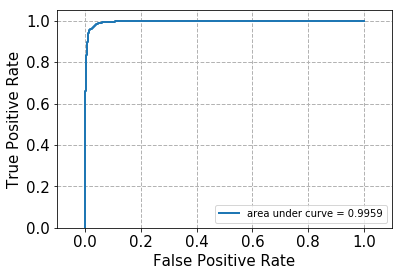

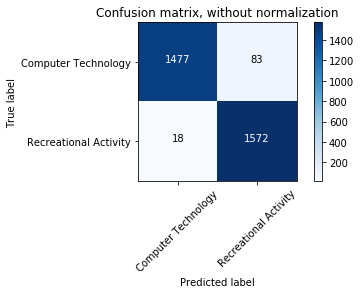

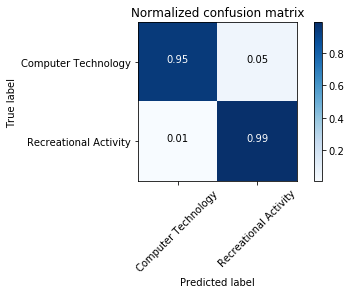

In [16]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=1000)
fit_predict_and_plot(clf, train_lsi, train_ds.target, test_lsi, test_ds.target, train_ds.target_names)

<h2>Soft Margin Linear SVM</h2>

Confusion matrix, without normalization
[[ 388 1172]
 [   0 1590]]
Normalized confusion matrix
[[0.25 0.75]
 [0.   1.  ]]
accuracy:0.6279365079365079
precision:0.5756698044895003
recall:1.0
f1:0.7306985294117647


LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

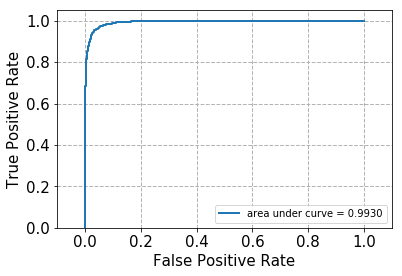

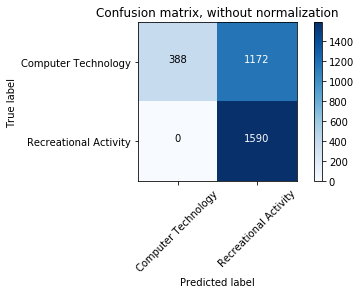

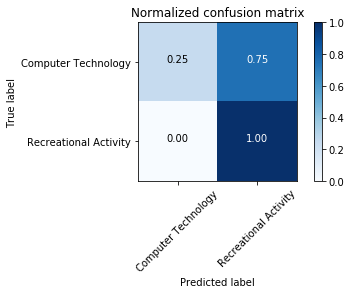

In [17]:
clf = LinearSVC(C=0.0001)
fit_predict_and_plot(clf, train_lsi, train_ds.target, test_lsi, test_ds.target, train_ds.target_names)

<h3>Which one performs better?</h3>
<p>Hard Margin SVM performs better since the F1-score for Hard Margin SVM is 0.971196, compared to 0.730698 for Soft Margin SVM</p>

<h3>What happens for the soft margin SVM? Why is the case?</h3>
<p>Soft Margin SVM has more misclassifications and is penalized more than Hard Margin SVM</p>

<h3>Cross Validation Results</h3>

In [18]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

svc_scores = {}
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    
for k in log_progress(range(-3, 4)):
    clf = LinearSVC(C=10**k)
    
    scores = cross_val_score(clf, train_lsi, train_ds.target, cv=cv, scoring='accuracy')
    print("LinearSVC k=%d: %f" %(k, scores.mean()))
    svc_scores[k] = scores.mean()
    
best_k = max(svc_scores, key=svc_scores.get)
print("Best k: %d (score = %f)" %(best_k, svc_scores[best_k]))

VBox(children=(HTML(value=''), IntProgress(value=0, max=7)))

LinearSVC k=-3: 0.881268
LinearSVC k=-2: 0.967183
LinearSVC k=-1: 0.973239
LinearSVC k=0: 0.975070
LinearSVC k=1: 0.976479
LinearSVC k=2: 0.976056
LinearSVC k=3: 0.971127
Best k: 1 (score = 0.976479)


<h2>K=1 Linear SVM plots and scores</h2>

Confusion matrix, without normalization
[[1499   61]
 [  35 1555]]
Normalized confusion matrix
[[0.96 0.04]
 [0.02 0.98]]
accuracy:0.9695238095238096
precision:0.9622524752475248
recall:0.9779874213836478
f1:0.9700561447286339


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

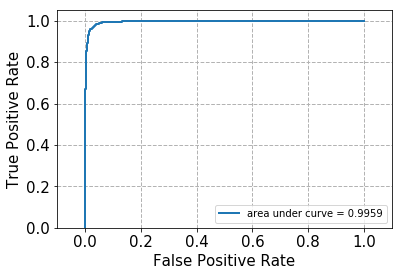

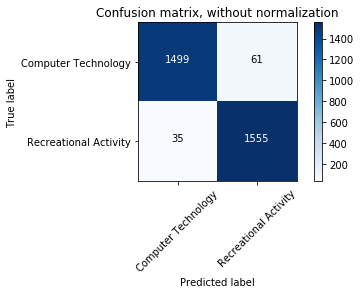

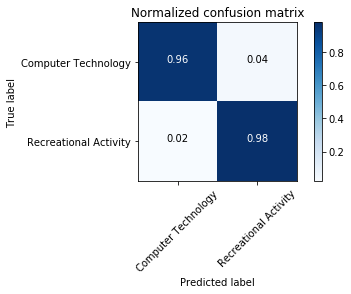

In [19]:
clf = LinearSVC(C=10)
fit_predict_and_plot(clf, train_lsi, train_ds.target, test_lsi, test_ds.target, train_ds.target_names)